In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.stats import ttest_ind, ttest_rel
import statsmodels.api as smi
from scipy.special import ndtri
from scipy.integrate import quad
#from scipy.stats import t
from scipy import stats
from statsmodels.formula.api import ols

In [25]:
# таблица данных об учениках и проведении теста
df = pd.read_csv('StudentsPerformance.csv')
df

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95
996,male,group C,high school,free/reduced,none,62,55,55
997,female,group C,high school,free/reduced,completed,59,71,65
998,female,group D,some college,standard,completed,68,78,77


In [27]:
df = df.rename(columns={'test preparation course':'test_preparation_course', 'math score':'math_score', 'reading score': 'reading_score','writing score':'writing_score','race/ethnicity':'race'})
df

,gender,race,parental level of education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95
996,male,group C,high school,free/reduced,none,62,55,55
997,female,group C,high school,free/reduced,completed,59,71,65
998,female,group D,some college,standard,completed,68,78,77


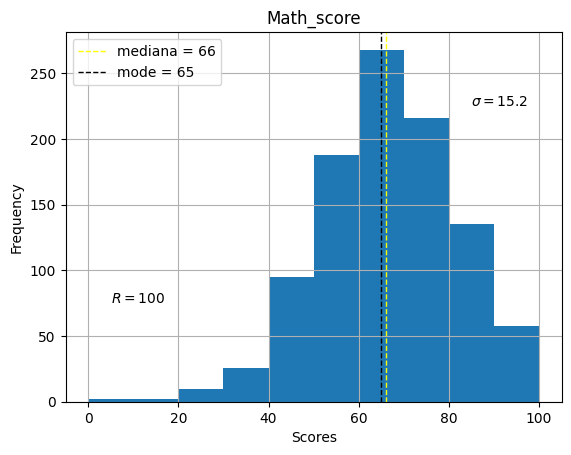

In [5]:
# построение результатов теста по математике
# анализ мер тенденции и мер изменчивости
fig, axs = plt.subplots()
axs.set_title('Math_score')
axs.set_xlabel('Scores')
axs.set_ylabel('Frequency')
axs.axvline(df.math_score.median(), color='yellow', linestyle='dashed', linewidth=1, label = f'mediana = {int(df.math_score.median())}')
#axs.axvline(df.math_score.mean(), color='yellow', linestyle='dashed', linewidth=1, label = 'mean')
axs.axvline(df.math_score.mode()[0], color='black', linestyle='dashed', linewidth=1, label = f'mode = {df.math_score.mode()[0]}')
df.math_score.hist(ax=axs)
plt.legend(loc='upper left')
plt.text(85, 225, f'$\sigma = {round(df.math_score.std(),1)}$')
plt.text(5, 75, f'$R = {round(df.math_score.max() - df.math_score.min(),1)}$');

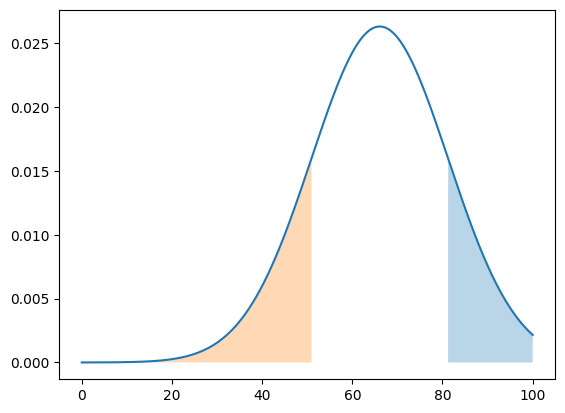

In [6]:
# доверительный интервал для результатов по математике
 
mean, std  = df.math_score.mean(), df.math_score.std()
# создадим пространство из 1000 точек в диапазоне +/- трех СКО от среднего значения
x = np.linspace(df.math_score.min(), df.math_score.max(), 1000)
 
# рассчитаем значения по оси y с помощью метода .pdf()
# т.е. функции плотности распределения
f = norm.pdf(x, mean, std)
 
# и построим график
plt.plot(x, f)
 
# дополнительно создадим точки на оси х для закрашенной области
px_1 = np.linspace(mean + std, df.math_score.max(), 1000)
px_2 = np.linspace(df.math_score.min(), mean - std, 1000)
 
# и заполним в пределах этих точек по оси x пространство
# от кривой нормального распределения до оси y = 0
plt.fill_between(px_1, norm.pdf(px_1, mean, std), alpha = 0.3)
plt.fill_between(px_2, norm.pdf(px_2, mean, std), alpha = 0.3)
 
# выведем оба графика
plt.show()

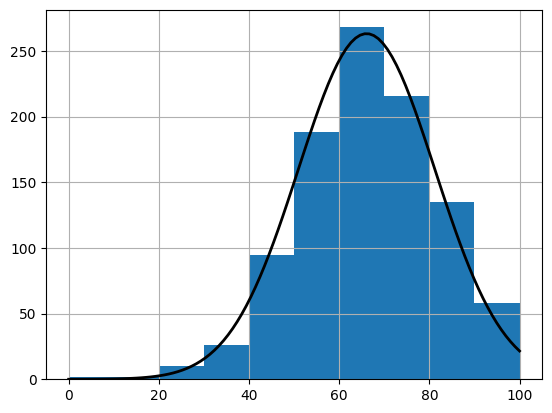

In [7]:
# проверка данных на нормальность по гистограмме
mu, std = norm.fit(df.math_score.head(999))
x = np.linspace(0, 100, 100)
p = norm.pdf(x, mu, std) # функция плотности вероятности
df.math_score.hist()
plt.plot(x, p*10**4, 'k', linewidth=2);


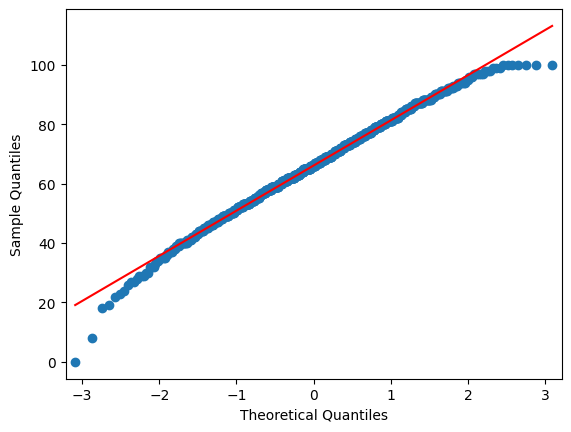

In [8]:
# проверка нормальность данных через Q-Q plot
smi.qqplot(df.math_score, line="r") 
plt.show() 

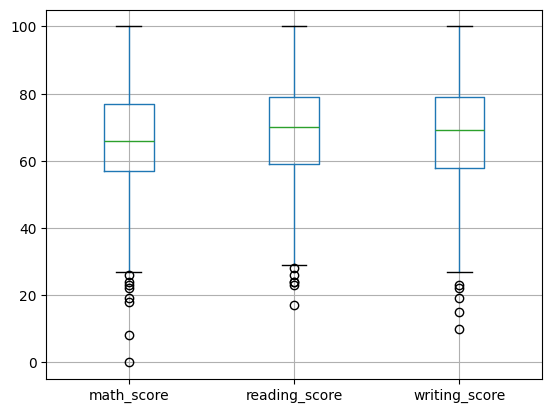

In [9]:
# построение результатов тестов на boxplot. По величине выбросов можно сказать, какой предмет написали хуже всего
df.boxplot(column=['math_score', 'reading_score', 'writing_score']);

In [10]:
# t - тест Стюдента. Количественная переменная - оценки по математике, номинативная - пол студентов
# нулевая гипотеза H_0 - одинаковые средние, нет различий между полом
# ограничение метода - нормальность данных и гомогенность дисперсий
# существует проблема множественного стравнения t-теста - это можно отдельно показать
n = len(df.math_score) # размер выборки
df1 = df.groupby('gender').aggregate({'math_score': 'mean'})
df1 = df1.rename(columns={'math_score':"mean"})
df1['std'] = df.groupby('gender').aggregate({'math_score': 'std'})
df1

,mean,std
gender,,
female,63.633205,15.491453
male,68.728216,14.356277


In [11]:
# расчёт t-критерия для сравнения двух средних
t = (df1.loc['female']['mean'] - df1.loc['male']['mean'])/np.sqrt(df1.loc['female']['std']**2/482+ df1.loc['male']['std']**2/518)
print(t)

-5.383260578852784


In [12]:
df_male = df.loc[df.gender =='male'].math_score
df_female = df.loc[df.gender =='female'].math_score

In [13]:
# p-уровень значимости оказался < 0.05, отклоняется нулевая гипотеза, получили значимые различия
t_statistic, p_value = ttest_ind(df_male, df_female)
print(t_statistic, p_value)

5.383245869828983 9.120185549328822e-08


In [14]:
# p-value можно посчитать вручную, т.к t-распределение по степени свободы df = 998 практически нормальное
area = norm.cdf(t, loc=0, scale = 1) # cdf - кумулятивная функция распределения, 
area1 = norm.cdf(-t, loc=0, scale = 1)
p_value_1 = 2*area
print(p_value_1) # отличие от p_value из ttest_ind, что там было всё рассчитано для t-функции

7.314852348369206e-08


In [15]:
# если более точное значение p_value, воспользуемся t распределением из scipy.stats

#p_value = 2*t.cdf(-5.383260578852784, 998, loc=0, scale=1)
#p_value

In [16]:
# можно построить t-распределение из библиотеки scipy.stats
#distribution = np.linspace(-10, 10, 1000)
#plot = plt.plot(distribution, t(998,0).pdf(distribution))

In [17]:
# t-тест можно проводить при гомогенности дисперсий
# можно проверить с помощью теста Барлетта или Левена
# тест Барлетта чувствителен к нормальности
stat, p = stats.bartlett(df_male, df_female)
print(p)
# видно, что t-тест можно использовать, но крайне осторожно. Либо нужно воспользоваться более точным методом
levene_stat, p_value = stats.levene(df_male, df_female) # метод Левена является более точным методом
print(p_value) # дисперсии одинаковые, можем использовать t-тест

0.03849937881025385
0.5563091575199801


In [18]:
#Однофакторный дисперсионный анализ - - взаимосвязь нескольких групп (равенство среднего значения)
# Более необходимо для проверки > 2 групп
f_statistic, p_value = stats.f_oneway(df_male, df_female)
print(f_statistic, p_value) # f-статистика значима, следовательно, разные средние. Аналогично говорит и p-value
#F-статистика считается через суума квадратов отклонений внутригрупповую(SSW) и межгрупповую(SSB)
# SSB >> SSW - значительные различия
# SSW >> SSB - различий нет

28.979336095030884 9.120185549332254e-08


In [ ]:
# в данном случае мы можем проверить также на взаимосвзять результатов тестов
f_statistic, p_value = stats.f_oneway(df.math_score, df.reading_score, df.writing_score) # f-статистика значима, следовательно, разные средние. Аналогично говорит и p-value
print(f_statistic, p_value)

10.824191628378626 2.0701893192229333e-05


In [33]:
df_A = df.loc[df.race == 'group A'].math_score
df_B = df.loc[df.race == 'group B'].math_score
df_C = df.loc[df.race == 'group C'].math_score
df_D = df.loc[df.race == 'group D'].math_score
df_E = df.loc[df.race == 'group E'].math_score

In [40]:
# люди независимости от этнической принадлежности A,B,C тест по математике написали примерно одинаково
f_statistic, p_value = stats.f_oneway(df_A,df_B,df_C)
print(f_statistic, p_value)
f_statistic, p_value = stats.f_oneway(df_A,df_B,df_C,df_D,df_E) # D и E внесли существенное различие
print(f_statistic, p_value)

1.2865292354788134 0.2769951028770473
14.593885166332635 1.3732194030370688e-11


In [46]:
# можно осуществлять двухфакторный дисперсионный анализ - по полу и по принадлежности к группе
model = ols('math_score ~ C(race) + C(gender) + C(race):C(gender)', data=df).fit() # каждый из факторов слабо по отдельности влияет на результат теста, а вот оба оказывают значительное влияние
anova_result = smi.stats.anova_lm(model, type=2)
anova_result
# необходимо построить графики для anova, чтобы показать роль взаимодействий

,df,sum_sq,mean_sq,F,PR(>F)
C(race),4.0,12728.816698,3182.204175,14.958723,7.080942e-12
C(gender),1.0,6241.471075,6241.471075,29.339549,7.626657e-08
C(race):C(gender),4.0,113.770679,28.442670,0.133702,9.699848e-01
Residual,990.0,210605.020548,212.732344,NaN,NaN
